In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2



In [2]:
DATADIR= r"C:\Users\tanvi\dataset\training_set"
CATEGORIES = ["dogs","cats"]


In [3]:
training_data=[]

def prepare_train_data():
    for category in CATEGORIES:
        path = os.path.join(DATADIR, category)
        class_num = CATEGORIES.index(category)
        for img in os.listdir(path):
            try:
                img_array = cv2.imread(os.path.join(path,img), cv2.IMREAD_GRAYSCALE)
                new_array = cv2.resize(img_array,(50,50))
                training_data.append([new_array, class_num])
            except Exception as e:
                pass
 
prepare_train_data()        

In [4]:
print(len(training_data))

8000


In [5]:
import random 
random.shuffle(training_data)

In [6]:
for sample in training_data[:1]:
    print(sample[0].shape)

(50, 50)


In [7]:
X= []
Y= []


In [8]:
for feature, label in training_data:
    X.append(feature)
    Y.append(label)   
    
  
X = np.array(X).reshape(-1, 50, 50, 1)    

In [9]:
X.shape

(8000, 50, 50, 1)

In [10]:
train_x_flatten = X.reshape(X.shape[0], -1).T   # The "-1" makes reshape flatten the remaining dimensions


# Standardize data to have feature values between 0 and 1.
train_x = train_x_flatten/255.


#print ("train_x's shape: " + str(train_x.shape))




In [11]:
train_x[0]

array([0.61176471, 0.82352941, 0.3372549 , ..., 0.77254902, 0.01960784,
       0.1254902 ])

In [12]:
print(train_x.shape)

(2500, 8000)


In [13]:
import numpy as np
import h5py
import matplotlib.pyplot as plt
import math

In [14]:
%matplotlib inline
plt.rcParams['figure.figsize'] = (5.0, 4.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

%load_ext autoreload
%autoreload 2

np.random.seed(1)

In [15]:
import numpy as np

def sigmoid(Z):
    """
    Implements the sigmoid activation in numpy
    
    Arguments:
    Z -- numpy array of any shape
    
    Returns:
    A -- output of sigmoid(z), same shape as Z
    cache -- returns Z as well, useful during backpropagation
    """
    
    A = 1/(1+np.exp(-Z))
    cache = Z
    
    return A, cache

def relu(Z):
    """
    Implement the RELU function.

    Arguments:
    Z -- Output of the linear layer, of any shape

    Returns:
    A -- Post-activation parameter, of the same shape as Z
    cache -- a python dictionary containing "A" ; stored for computing the backward pass efficiently
    """
    
    A = np.maximum(0,Z)
    
    assert(A.shape == Z.shape)
    
    cache = Z 
    return A, cache


def relu_backward(dA, cache):
    """
    Implement the backward propagation for a single RELU unit.

    Arguments:
    dA -- post-activation gradient, of any shape
    cache -- 'Z' where we store for computing backward propagation efficiently

    Returns:
    dZ -- Gradient of the cost with respect to Z
    """
    
    Z = cache
    dZ = np.array(dA, copy=True) # just converting dz to a correct object.
    
    # When z <= 0, you should set dz to 0 as well. 
    dZ[Z <= 0] = 0
    
    assert (dZ.shape == Z.shape)
    
    return dZ

def sigmoid_backward(dA, cache):
    """
    Implement the backward propagation for a single SIGMOID unit.

    Arguments:
    dA -- post-activation gradient, of any shape
    cache -- 'Z' where we store for computing backward propagation efficiently

    Returns:
    dZ -- Gradient of the cost with respect to Z
    """
    
    Z = cache
    
    s = 1/(1+np.exp(-Z))
    dZ = dA * s * (1-s)
    
    assert (dZ.shape == Z.shape)
    
    return dZ



In [16]:
# GRADED FUNCTION: initialize_parameters_deep

def initialize_parameters_deep(layer_dims):
  
    np.random.seed(3)
    parameters = {}
    L = len(layer_dims)            # number of layers in the network

    for l in range(1, L):
        ### START CODE HERE ### (≈ 2 lines of code)
        parameters['W' + str(l)] = np.random.randn(layer_dims[l], layer_dims[l-1]) * np.sqrt(2/layer_dims[l-1])
        parameters['b' + str(l)] = np.zeros((layer_dims[l],1))
        ### END CODE HERE ###
        
        assert(parameters['W' + str(l)].shape == (layer_dims[l], layer_dims[l-1]))
        assert(parameters['b' + str(l)].shape == (layer_dims[l], 1))

        
    return parameters
 

In [17]:
def linear_forward(A,W,b):

    Z = W @ A + b
    cache = (A,W,b)

    return Z,cache

In [18]:
def linear_activation_forward(A_prev, W, b, activation):

    if activation=="sigmoid":
        Z, linear_cache = linear_forward(A_prev, W, b)
        A, activation_cache = sigmoid(Z)
    elif activation== "relu":
        Z,linear_cache = linear_forward(A_prev, W, b)
        A, activation_cache = relu(Z)

    cache = (linear_cache, activation_cache)
    return A, cache    

In [19]:
def L_model_forward(X, parameters):

    caches = []
    A = X
    L = len(parameters) // 2

    for l in range(1,L):
        A_prev = A
        A, cache = linear_activation_forward(A_prev, parameters['W{:d}'.format(l)], parameters['b{:d}'.format(l)], activation='relu')
        caches.append(cache)

    AL,cache = linear_activation_forward(A, parameters['W%d' % L], parameters['b%d' % L], activation='sigmoid')
    caches.append(cache)
    return AL,caches  

In [20]:
#cost calculation
def compute_cost(AL, Y):

    m = Y.shape[1]

    cost = -1/m * np.sum(Y*np.log(AL)+(1-Y)*np.log(1-AL))

    cost = np.squeeze(cost)
    return cost

In [21]:
def compute_cost_with_regularization(AL, Y , parameters, lambd):
    m=Y.shape[1]
    cross_entropy_cost=compute_cost(AL,Y)
    
    L = len(parameters)//2
    

    L2_regula_cost = 1/m * lambd/2 * (np.sum(np.square(parameters['W1']))+np.sum(np.square(parameters['W2']))+np.sum(np.square(parameters['W3']))+np.sum(np.square(parameters['W4'])))
    
    cost = cross_entropy_cost+L2_regula_cost
    return cost

In [22]:
#backpropagation
def linear_backward(dZ, cache):

    A_prev, W, b = cache
    m = A_prev.shape[1]

    dW = 1/m* dZ @ A_prev.T
    db = 1/m* np.sum(dZ, axis=1, keepdims=True)
    dA_prev = W.T @ dZ

    return dA_prev, dW, db

In [23]:
def linear_activation_backward(dA, cache, activation):

    linear_cache, activation_cache = cache

    if activation == "sigmoid":
        dZ = sigmoid_backward(dA, activation_cache)
        dA_prev, dW, db = linear_backward(dZ, linear_cache)

    elif activation =="relu":
        dZ = relu_backward(dA, activation_cache)
        dA_prev, dW, db = linear_backward(dZ, linear_cache)
    return dA_prev, dW, db    

In [24]:
def L_model_backward(AL, Y, caches):
    grads={}
    L=len(caches)
    m = AL.shape[1]
    Y = Y.reshape(AL.shape)

    dAL = -(np.divide(Y,AL) - np.divide(1-Y, 1-AL))

    current_cache = caches[L-1]
    grads["dA" + str(L-1)], grads["dW" + str(L)], grads["db" + str(L)] = linear_activation_backward(dAL, current_cache,'sigmoid')

    for l in reversed(range(L-1)):
        current_cache = caches[l]
        dA_prev_temp, dW_temp, db_temp = linear_activation_backward(grads["dA"+str(l+1)], current_cache,'relu')
        grads["dA" + str(l)] = dA_prev_temp
        grads["dW" + str(l + 1)] = dW_temp
        grads["db" + str(l + 1)] = db_temp

    return grads  




In [25]:
def update_parameters(parameters, grads, learning_rate):

    L= len(parameters) //2

    for l in range(L):
        parameters["W" + str(l+1)] = parameters["W" + str(l+1)] -learning_rate * grads["dW"+str(l+1)]
        parameters["b" + str(l+1)] = parameters["b" + str(l+1)] -learning_rate * grads["db"+str(l+1)]
        
        
    print(len(parameters))
    print(len(grads))
    #print(parameters)    
    return parameters   

In [26]:

layers_dims = [2500,20,7,5,1]
print(len(layers_dims))

5


In [27]:
# GRADED FUNCTION: L_layer_model

def L_layer_model(X, Y, layers_dims, learning_rate = 0.0075,lambd=0.7, num_iterations = 3000, print_cost=False):#lr was 0.009
    """
    Implements a L-layer neural network: [LINEAR->RELU]*(L-1)->LINEAR->SIGMOID.
    
    Arguments:
    X -- data, numpy array of shape (num_px * num_px * 3, number of examples)
    Y -- true "label" vector (containing 0 if cat, 1 if non-cat), of shape (1, number of examples)
    layers_dims -- list containing the input size and each layer size, of length (number of layers + 1).
    learning_rate -- learning rate of the gradient descent update rule
    num_iterations -- number of iterations of the optimization loop
    print_cost -- if True, it prints the cost every 100 steps
    
    Returns:
    parameters -- parameters learnt by the model. They can then be used to predict.
    """
    print(Y)
    np.random.seed(1)
    costs = []                         # keep track of cost
    
    # Parameters initialization. (≈ 1 line of code)
    ### START CODE HERE ###
    parameters = initialize_parameters_deep(layers_dims)
    ### END CODE HERE ###
    
    # Loop (gradient descent)
    for i in range(0, num_iterations):

        # Forward propagation: [LINEAR -> RELU]*(L-1) -> LINEAR -> SIGMOID.
        ### START CODE HERE ### (≈ 1 line of code)
        AL, caches = L_model_forward(X, parameters)
        ### END CODE HERE ###
        
        # Compute cost.
        ### START CODE HERE ### (≈ 1 line of code)
        cost = compute_cost_with_regularization(AL, Y, parameters,lambd)
        ### END CODE HERE ###
    
        # Backward propagation.
        ### START CODE HERE ### (≈ 1 line of code)
        grads = L_model_backward(AL, Y, caches)
        ### END CODE HERE ###
 
        # Update parameters.
        ### START CODE HERE ### (≈ 1 line of code)
        parameters = update_parameters(parameters, grads, learning_rate)
        ### END CODE HERE ###
                
        # Print the cost every 100 training example
        if print_cost and i % 100 == 0:
            print ("Cost after iteration %i: %f" %(i, cost))
        if print_cost and i % 100 == 0:
            costs.append(cost)
            
    # plot the cost
    plt.plot(np.squeeze(costs))
    plt.ylabel('cost')
    plt.xlabel('iterations (per hundreds)')
    plt.title("Learning rate =" + str(learning_rate))
    plt.show()
    
    return parameters

In [28]:
Y = np.array(Y).reshape(1,8000)
print(train_x.shape)
print(Y.shape)

(2500, 8000)
(1, 8000)


[[1 1 1 ... 0 1 1]]
8
12
Cost after iteration 0: 0.716397
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
Cost after iteration 100: 0.689672
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8


8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
Cost after iteration 1600: 0.644662
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
Cost after iteration 1700: 0.642408
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
1

8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
Cost after iteration 3100: 0.612352
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
Cost after iteration 3200: 0.611261
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
1

8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
Cost after iteration 4600: 0.590072
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
Cost after iteration 4700: 0.588296
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
1

8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
Cost after iteration 6200: 0.560146
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
Cost

8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
Cost after iteration 7700: 0.527896
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
Cost after iteration 7800: 0.526591
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
12
8
1

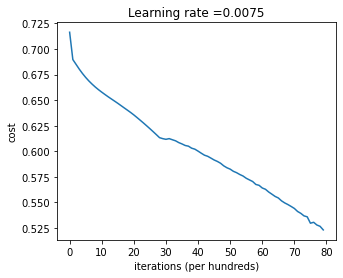

In [29]:
parameters = L_layer_model(train_x, Y, layers_dims, num_iterations = 8000, print_cost = True)

In [30]:
#parameters = two_layer_model(train_x, Y, layers_dims = (n_x, n_h, n_y), num_iterations = 8000, print_cost=True)

In [31]:
def predict(X, y, parameters):
    """
    This function is used to predict the results of a  L-layer neural network.
    
    Arguments:
    X -- data set of examples you would like to label
    parameters -- parameters of the trained model
    
    Returns:
    p -- predictions for the given dataset X
    """
    
    m = X.shape[1]
    n = len(parameters) // 2 # number of layers in the neural network
    p = np.zeros((1,m))
    
    # Forward propagation
    probas, caches = L_model_forward(X, parameters)

    
    # convert probas to 0/1 predictions
    for i in range(0, probas.shape[1]):
        if probas[0,i] > 0.5:
            p[0,i] = 1
        else:
            p[0,i] = 0
    
    #print results
    #print ("predictions: " + str(p))
    #print ("true labels: " + str(y))
    print("Accuracy: "  + str(np.sum((p == y)/m)))
        
    return p

In [32]:
def L_model_forward(X, parameters):
    """
    Implement forward propagation for the [LINEAR->RELU]*(L-1)->LINEAR->SIGMOID computation
    
    Arguments:
    X -- data, numpy array of shape (input size, number of examples)
    parameters -- output of initialize_parameters_deep()
    
    Returns:
    AL -- last post-activation value
    caches -- list of caches containing:
                every cache of linear_relu_forward() (there are L-1 of them, indexed from 0 to L-2)
                the cache of linear_sigmoid_forward() (there is one, indexed L-1)
    """

    caches = []
    A = X
    L = len(parameters) // 2                  # number of layers in the neural network
    
    # Implement [LINEAR -> RELU]*(L-1). Add "cache" to the "caches" list.
    for l in range(1, L):
        A_prev = A 
        A, cache = linear_activation_forward(A_prev, parameters['W' + str(l)], parameters['b' + str(l)], activation = "relu")
        caches.append(cache)
    
    # Implement LINEAR -> SIGMOID. Add "cache" to the "caches" list.
    AL, cache = linear_activation_forward(A, parameters['W' + str(L)], parameters['b' + str(L)], activation = "sigmoid")
    caches.append(cache)
    
    assert(AL.shape == (1,X.shape[1]))
            
    return AL, caches

In [33]:
predictions_train = predict(train_x, Y, parameters)

Accuracy: 0.7343750000000002
